# Relations réciproques entres personnes et avec les institutions

In [589]:
import pandas as pd
import networkx as nx
import matplotlib.pyplot as plt
from itables import init_notebook_mode, show
import numpy as np
import seaborn as sns
from netgraph import Graph, InteractiveGraph
from pyvis.network import Network
import math

## Production des données

* Requête exécutée sur le serveur https://dbpedia.org/sparql 
* Période élargie jusqu'aux comtemporains-nes
* Propriétés prises en compte après inspection des propriétés de la population:
  * http://dbpedia.org/ontology/almaMater 
  * http://dbpedia.org/ontology/institution


```SPARQL
PREFIX dbr: <http://dbpedia.org/resource/>
PREFIX dbp: <http://dbpedia.org/property/>
PREFIX dbo: <http://dbpedia.org/ontology/>
PREFIX rdfs:<http://www.w3.org/2000/01/rdf-schema#>
SELECT DISTINCT (?o1 AS ?subject_uri) ?subjectBirthDate ?r_property ?target (xsd:integer(SUBSTR(STR(?normalizedDate), 1, 4)) AS ?birthYear)
WHERE {
  SELECT DISTINCT ?o1 ?subjectBirthDate ?r_property ?target (STRDT(REPLACE(STR(?subjectBirthDate), "[^0-9\\-]", ""), xsd:date) AS ?normalizedDate)
  WHERE {
    ?o1 ?p dbr:Poet.
    ?o1 a dbo:Person;
      (dbp:birthDate | dbo:birthDate) ?subjectBirthDate.
    {
      {?o1 dbo:almaMater ?target.
       BIND('almaMater' AS ?r_property)}
      UNION
      {?o1 dbo:institution ?target.
       BIND('institution' AS ?r_property)}
      #UNION
      #{?o1 dbp:fields ?target.
      # BIND('fields' AS ?r_property)}
      #UNION
      #{?o1 dbp:field ?target.
      # BIND('field' AS ?r_property)}
    }
  }
}
ORDER BY ?birthYear

```

In [590]:
path = 'data/poets_relations.csv'

df = pd.read_csv(path)

### Inspecter les dimensions et les 3 premières et dernières lignes
print(df.shape, df.head(5), '\n\n-----\n', df.tail(5))

(1869, 1)   subject_uri;subjectBirthDate;r_property;target;birthYear
0  http://dbpedia.org/resource/Anna_Smaill;1979  ...      
1  http://dbpedia.org/resource/Anna_Smaill;1979  ...      
2  http://dbpedia.org/resource/Anna_Smaill;1979  ...      
3  http://dbpedia.org/resource/Vladimir_Mayakovsk...      
4  http://dbpedia.org/resource/Vladimir_Mayakovsk...       

-----
      subject_uri;subjectBirthDate;r_property;target;birthYear
1864  http://dbpedia.org/resource/Pratyush_Prakash;3...      
1865  http://dbpedia.org/resource/Cyrus_Grace_Dunham...      
1866  http://dbpedia.org/resource/Amata_Giramata;350...      
1867  http://dbpedia.org/resource/Amata_Giramata;350...      
1868  http://dbpedia.org/resource/Amanda_Gorman;3586...      


In [591]:
### Ouvrir le fichier et créer un DataFrame
fd = 'data/poets_relations.csv'
df = pd.read_csv(fd)
len(df)

1869

In [592]:
# Spécifiez le délimiteur lors de la lecture du fichier CSV
df = pd.read_csv('data/poets_relations.csv', delimiter=';')

# Effectuez vos opérations sur le DataFrame
# ...

# Exemple : affichez les premières lignes du DataFrame
print(df.head())

                                       subject_uri subjectBirthDate   
0          http://dbpedia.org/resource/Anna_Smaill         1979      \
1          http://dbpedia.org/resource/Anna_Smaill         1979       
2          http://dbpedia.org/resource/Anna_Smaill         1979       
3  http://dbpedia.org/resource/Vladimir_Mayakovsky       0001-07-19   
4  http://dbpedia.org/resource/Vladimir_Mayakovsky       0001-07-19   

  r_property                                             target  birthYear  
0  almaMater  http://dbpedia.org/resource/University_College...        NaN  
1  almaMater  http://dbpedia.org/resource/University_of_Auck...        NaN  
2  almaMater  http://dbpedia.org/resource/Victoria_Universit...        NaN  
3  almaMater  http://dbpedia.org/resource/Moscow_School_of_P...        NaN  
4  almaMater  http://dbpedia.org/resource/Stroganov_Moscow_S...        NaN  


In [593]:
### Raccourcir l'URI, extraire l'année de naissance
df['subject_uri'] = df['subject_uri'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
df['target'] = df['target'].apply(lambda x : x.replace('http://dbpedia.org/resource/', ''))
df['BirthYear'] = df['subjectBirthDate'].apply(lambda x : int(x[:4]) if isinstance(x, str) else x)

In [594]:
### Ajouter deux périodes différentes en fonctions de la relation
# Pour la relation 'étudier' créer une période entre 18 et 28 ans (+17, +27) pour l'étendue des études
# Pour la relation 'insitution' ajouté une période d'activité de 19 à 65 ans
df['YBegin'] = df[['BirthYear', 'r_property']].apply(lambda x : int(x['BirthYear'] + 17) if x['r_property'] == 'almaMater' and not math.isnan(x['BirthYear']) else None, axis=1)
df['YEnd'] = df[['BirthYear', 'r_property']].apply(lambda x : int(x['BirthYear'] + 28) if x['r_property'] == 'almaMater' and not math.isnan(x['BirthYear']) else None, axis=1)

In [595]:
### Inspecter DataFrame
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1869 entries, 0 to 1868
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   subject_uri       1869 non-null   object 
 1   subjectBirthDate  1868 non-null   object 
 2   r_property        1869 non-null   object 
 3   target            1869 non-null   object 
 4   birthYear         1643 non-null   float64
 5   BirthYear         1868 non-null   float64
 6   YBegin            1861 non-null   float64
 7   YEnd              1861 non-null   float64
dtypes: float64(4), object(4)
memory usage: 116.9+ KB


In [596]:
### Inspecter la distribution des années de naissance
#df.BirthYear.describe()

In [597]:
### Inspecter la table 
# https://github.com/mwouts/itables/blob/main/docs/advanced_parameters.md
#show(df[['subject_uri','r_property','target','YBegin','YEnd','BirthYear']].sort_values(by='BirthYear'), classes="display", scrollY="200px", 
     #scrollCollapse=True, paging=False, column_filters="footer", dom="lrtip")

In [598]:
### Compter par propriété
#df.groupby(by='r_property').size()

In [599]:
# l_org_orig = list(df.target.unique()); len(l_org_orig), l_org_orig[:3]

In [600]:
### Effectuer et documenter tous les changements: nettoyage des données
df.loc[df.target == 'École_normale_supérieure_(Ulm)', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_normale_supérieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_Normale_Supérieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'École_Normale_Superieure', 'target']  = 'École_normale_supérieure_(Paris)'
df.loc[df.target == 'Swiss_Federal_Polytechnic', 'target']  = 'ETH_Zürich'
df.loc[df.target == 'Federal_Polytechnic_School', 'target']  = 'ETH_Zürich'
df.loc[df.target == 'Swiss_Federal_Institute_of_Technology_at_Zurich', 'target']  = 'ETH_Zürich'
df.loc[df.target == 'École_polytechnique', 'target']  = 'École_Polytechnique'
df.loc[df.target == 'University_of_Padua', 'target']  = 'Università_di_Padova'
df.loc[df.target == 'University_of_Padova', 'target']  = 'Università_di_Padova'

In [601]:
### Remplacements multiples, contenant Paris et Université
df.loc[(df.target.str.contains('Paris')) & (df.target.str.contains('Univ')), 'target'] = "Université_de_Paris"

In [602]:
organisations = df.groupby(by='target').size()
show(organisations.sort_index(ascending=False))

In [603]:
### Effectif total et les plus représentées
len(organisations), organisations.sort_values(ascending=False).head(10)

(852,
 target
 Harvard_University         36
 Columbia_University        33
 University_of_Michigan     19
 University_of_Coimbra      19
 Université_de_Paris        18
 University_of_Edinburgh    16
 University_of_Iowa         15
 University_of_Dhaka        14
 University_of_São_Paulo    14
 University_of_Belgrade     13
 dtype: int64)

### Explorer les années de naissance

In [604]:
s = df.BirthYear

In [605]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

#sns.set_theme(style="whitegrid")

#sns.set(rc={"figure.figsize":(14, 7)})

### Personnes nées avant 1931 (protection des données)
# a = s[(s<1931)] 
## Période antérieure
#a = s[(s<1801)]
### Période avec le plus de naissances de poètes
#a = s[(s>1300) & (s<2001)] # 

#lim_left=min(a)
#lim_right=max(a)





#ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
#ax.set_xlim(left=lim_left, right=lim_right)


#### Coder les périodes

In [606]:
bins=[1001,1801,1901,2021]

In [607]:
df['periode'] = pd.cut(df['BirthYear'], bins=bins, right=False  )
df.periode = df.periode.apply( lambda x : str(x.left) + '_' + str(x.right))

In [608]:
df.head()

,subject_uri,subjectBirthDate,r_property,target,birthYear,BirthYear,YBegin,YEnd,periode
0,Anna_Smaill,1979,almaMater,University_College_London,NaN,1979.0,1996.0,2007.0,1901_2021
1,Anna_Smaill,1979,almaMater,University_of_Auckland,NaN,1979.0,1996.0,2007.0,1901_2021
2,Anna_Smaill,1979,almaMater,Victoria_University_of_Wellington,NaN,1979.0,1996.0,2007.0,1901_2021
3,Vladimir_Mayakovsky,0001-07-19,almaMater,Moscow_School_of_Painting_Sculpture_and_Archit...,NaN,1.0,18.0,29.0,NaN
4,Vladimir_Mayakovsky,0001-07-19,almaMater,Stroganov_Moscow_State_University_of_Arts_and_...,NaN,1.0,18.0,29.0,NaN


In [609]:
### Effectif par période
df.groupby(by='periode').size()

periode
1001_1801    631
1801_1901    351
1901_2021    238
dtype: int64

In [610]:
### Dataframe to dictionary
# https://pandas.pydata.org/docs/reference/api/pandas.DataFrame.to_dict.html
ldf = df[['subject_uri', 'r_property', 'target',
       'YBegin', 'YEnd', 'BirthYear', 'periode']].sort_values(by='subject_uri').to_dict('records')

In [611]:
#ldf[:2]

## Graphe à deux types de sommets


Il s'agit d'un graphe de type 'bipartite', cf. la documentation de Networkx:

https://networkx.org/documentation/stable/reference/algorithms/bipartite.html

Nous n'utilisons toutefois pas ici les fonctions spécifiques de Neworkx.

In [612]:
l = []
for i in ldf:
    if i['periode'] == '1901_2021':
        l.append(tuple((i['subject_uri'],i['target'], 
                        {'relationship': i['r_property'], "birth_year": i['BirthYear'], "periode": i['periode'] })))
l[:5]

[('Aaron_McCollough',
  "Iowa_Writers'_Workshop",
  {'relationship': 'almaMater', 'birth_year': 1971.0, 'periode': '1901_2021'}),
 ('Aaron_McCollough',
  'North_Carolina_State_University',
  {'relationship': 'almaMater', 'birth_year': 1971.0, 'periode': '1901_2021'}),
 ('Aaron_McCollough',
  'University_of_the_South',
  {'relationship': 'almaMater', 'birth_year': 1971.0, 'periode': '1901_2021'}),
 ('Aaron_McCollough',
  'University_of_the_South',
  {'relationship': 'almaMater', 'birth_year': 1971.0, 'periode': '1901_2021'}),
 ('Aaron_McCollough',
  "Iowa_Writers'_Workshop",
  {'relationship': 'almaMater', 'birth_year': 1971.0, 'periode': '1901_2021'})]

In [613]:
# Graphe Personne- Organisation
POG=nx.Graph()

In [614]:
POG.add_edges_from(l)

In [615]:
### Principales caractéristiques de ce graphe

POG.is_multigraph(), POG.is_directed(), nx.is_connected(POG), POG.number_of_nodes(), POG.number_of_edges(), nx.density(POG)


(False, False, False, 308, 215, 0.004547569694149499)

In [616]:
### Créer une liste des organisations
l_org = list(organisations.index); len(l_org); l_org[:3]

['Abdul_Wali_Khan_University_Mardan',
 'Aberystwyth_University',
 'Academic_Gymnasium_Danzig']

In [617]:
list(POG.nodes.data())[:4]

[('Aaron_McCollough', {}),
 ("Iowa_Writers'_Workshop", {}),
 ('North_Carolina_State_University', {}),
 ('University_of_the_South', {})]

In [618]:
### Ajouter au sommets un code si personne ou organisation
# On utiliser pour ce faire la liste des organisations
types = {}
for e in list(POG.nodes):
    if e in l_org:
        t = 'O'
    else:
        t = 'P'
    types[e] = {'type': t} 
[(k,v )for k,v in types.items()][:3]  

[('Aaron_McCollough', {'type': 'P'}),
 ("Iowa_Writers'_Workshop", {'type': 'O'}),
 ('North_Carolina_State_University', {'type': 'O'})]

In [619]:
nx.set_node_attributes(POG, types)
list(POG.nodes.data())[:3]

[('Aaron_McCollough', {'type': 'P'}),
 ("Iowa_Writers'_Workshop", {'type': 'O'}),
 ('North_Carolina_State_University', {'type': 'O'})]

### Inspecter les centralités de degré

In [620]:
### Ajouter la centralité de degré
# grâce à un dictionnaire construit selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(POG)])

In [621]:
nx.set_node_attributes(POG, degree)

In [622]:
print(list(POG.nodes.data())[:4])

[('Aaron_McCollough', {'type': 'P', 'degree': 4}), ("Iowa_Writers'_Workshop", {'type': 'O', 'degree': 3}), ('North_Carolina_State_University', {'type': 'O', 'degree': 1}), ('University_of_the_South', {'type': 'O', 'degree': 1})]


In [623]:
persons_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'P':
        persons_degree.append([n[0], n[1]['degree']])

In [624]:
sorted(persons_degree, key = lambda x : x[1], reverse=True)[:10]

[['Aaron_McCollough', 4],
 ['Robert_Penn_Warren', 4],
 ['Robin_Coste_Lewis', 4],
 ['Saviana_Stănescu', 4],
 ['Anna_Smaill', 3],
 ['Ben_Doller', 3],
 ['Beth_Gylys', 3],
 ['Duane_Niatum', 3],
 ['Eleanor_Rees', 3],
 ['Johanny_Vazquez_Paz', 3]]

In [625]:
org_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'O':
        org_degree.append([n[0], n[1]['degree']])

In [626]:
sorted(org_degree, key = lambda x : x[1], reverse=True)[:10]

[['New_York_University', 4],
 ['University_of_Iowa', 4],
 ['Harvard_University', 4],
 ["Iowa_Writers'_Workshop", 3],
 ['University_of_Virginia', 3],
 ['University_of_Sydney', 3],
 ['Johns_Hopkins_University', 3],
 ['Yale_University', 3],
 ['University_of_California_Berkeley', 3],
 ['University_College_Cork', 3]]

In [627]:
edges = list(POG.edges.data())
edges[:5]

[('Aaron_McCollough',
  "Iowa_Writers'_Workshop",
  {'relationship': 'almaMater', 'birth_year': 1971.0, 'periode': '1901_2021'}),
 ('Aaron_McCollough',
  'North_Carolina_State_University',
  {'relationship': 'almaMater', 'birth_year': 1971.0, 'periode': '1901_2021'}),
 ('Aaron_McCollough',
  'University_of_the_South',
  {'relationship': 'almaMater', 'birth_year': 1971.0, 'periode': '1901_2021'}),
 ('Aaron_McCollough',
  'University_of_Michigan',
  {'relationship': 'almaMater', 'birth_year': 1971.0, 'periode': '1901_2021'}),
 ("Iowa_Writers'_Workshop",
  'Ben_Doller',
  {'relationship': 'almaMater', 'birth_year': 1973.0, 'periode': '1901_2021'})]

In [628]:
labels = {}    
for node in POG.nodes():
    labels[node] = node

In [629]:
nx.set_node_attributes(POG, labels, 'label')

In [630]:
nodes = list(POG.nodes.data())
nodes[:5]

[('Aaron_McCollough', {'type': 'P', 'degree': 4, 'label': 'Aaron_McCollough'}),
 ("Iowa_Writers'_Workshop",
  {'type': 'O', 'degree': 3, 'label': "Iowa_Writers'_Workshop"}),
 ('North_Carolina_State_University',
  {'type': 'O', 'degree': 1, 'label': 'North_Carolina_State_University'}),
 ('University_of_the_South',
  {'type': 'O', 'degree': 1, 'label': 'University_of_the_South'}),
 ('University_of_Michigan',
  {'type': 'O', 'degree': 2, 'label': 'University_of_Michigan'})]

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [631]:
components = nx.connected_components(POG);
components_l = [len(c) for c in sorted(nx.connected_components(POG), key=len, reverse=True)]
len(components_l), components_l[:5]

(93, [59, 9, 7, 6, 5])

In [632]:
S = [POG.subgraph(c).copy() for c in nx.connected_components(POG)]

In [633]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[0, 59], [29, 9], [28, 7], [39, 6], [1, 5], [13, 5], [33, 5], [44, 5]]

In [634]:
li=[n[0] for n in ln]

In [635]:
S[21].nodes 

NodeView(('University_of_Pula', 'Daniel_Načinović'))

### Représenter le graphe

In [636]:
u = S[14]

In [637]:
u = nx.Graph()
for i in li[:5]:
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [638]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


(False, False, 86, 81, 0.02216142270861833)

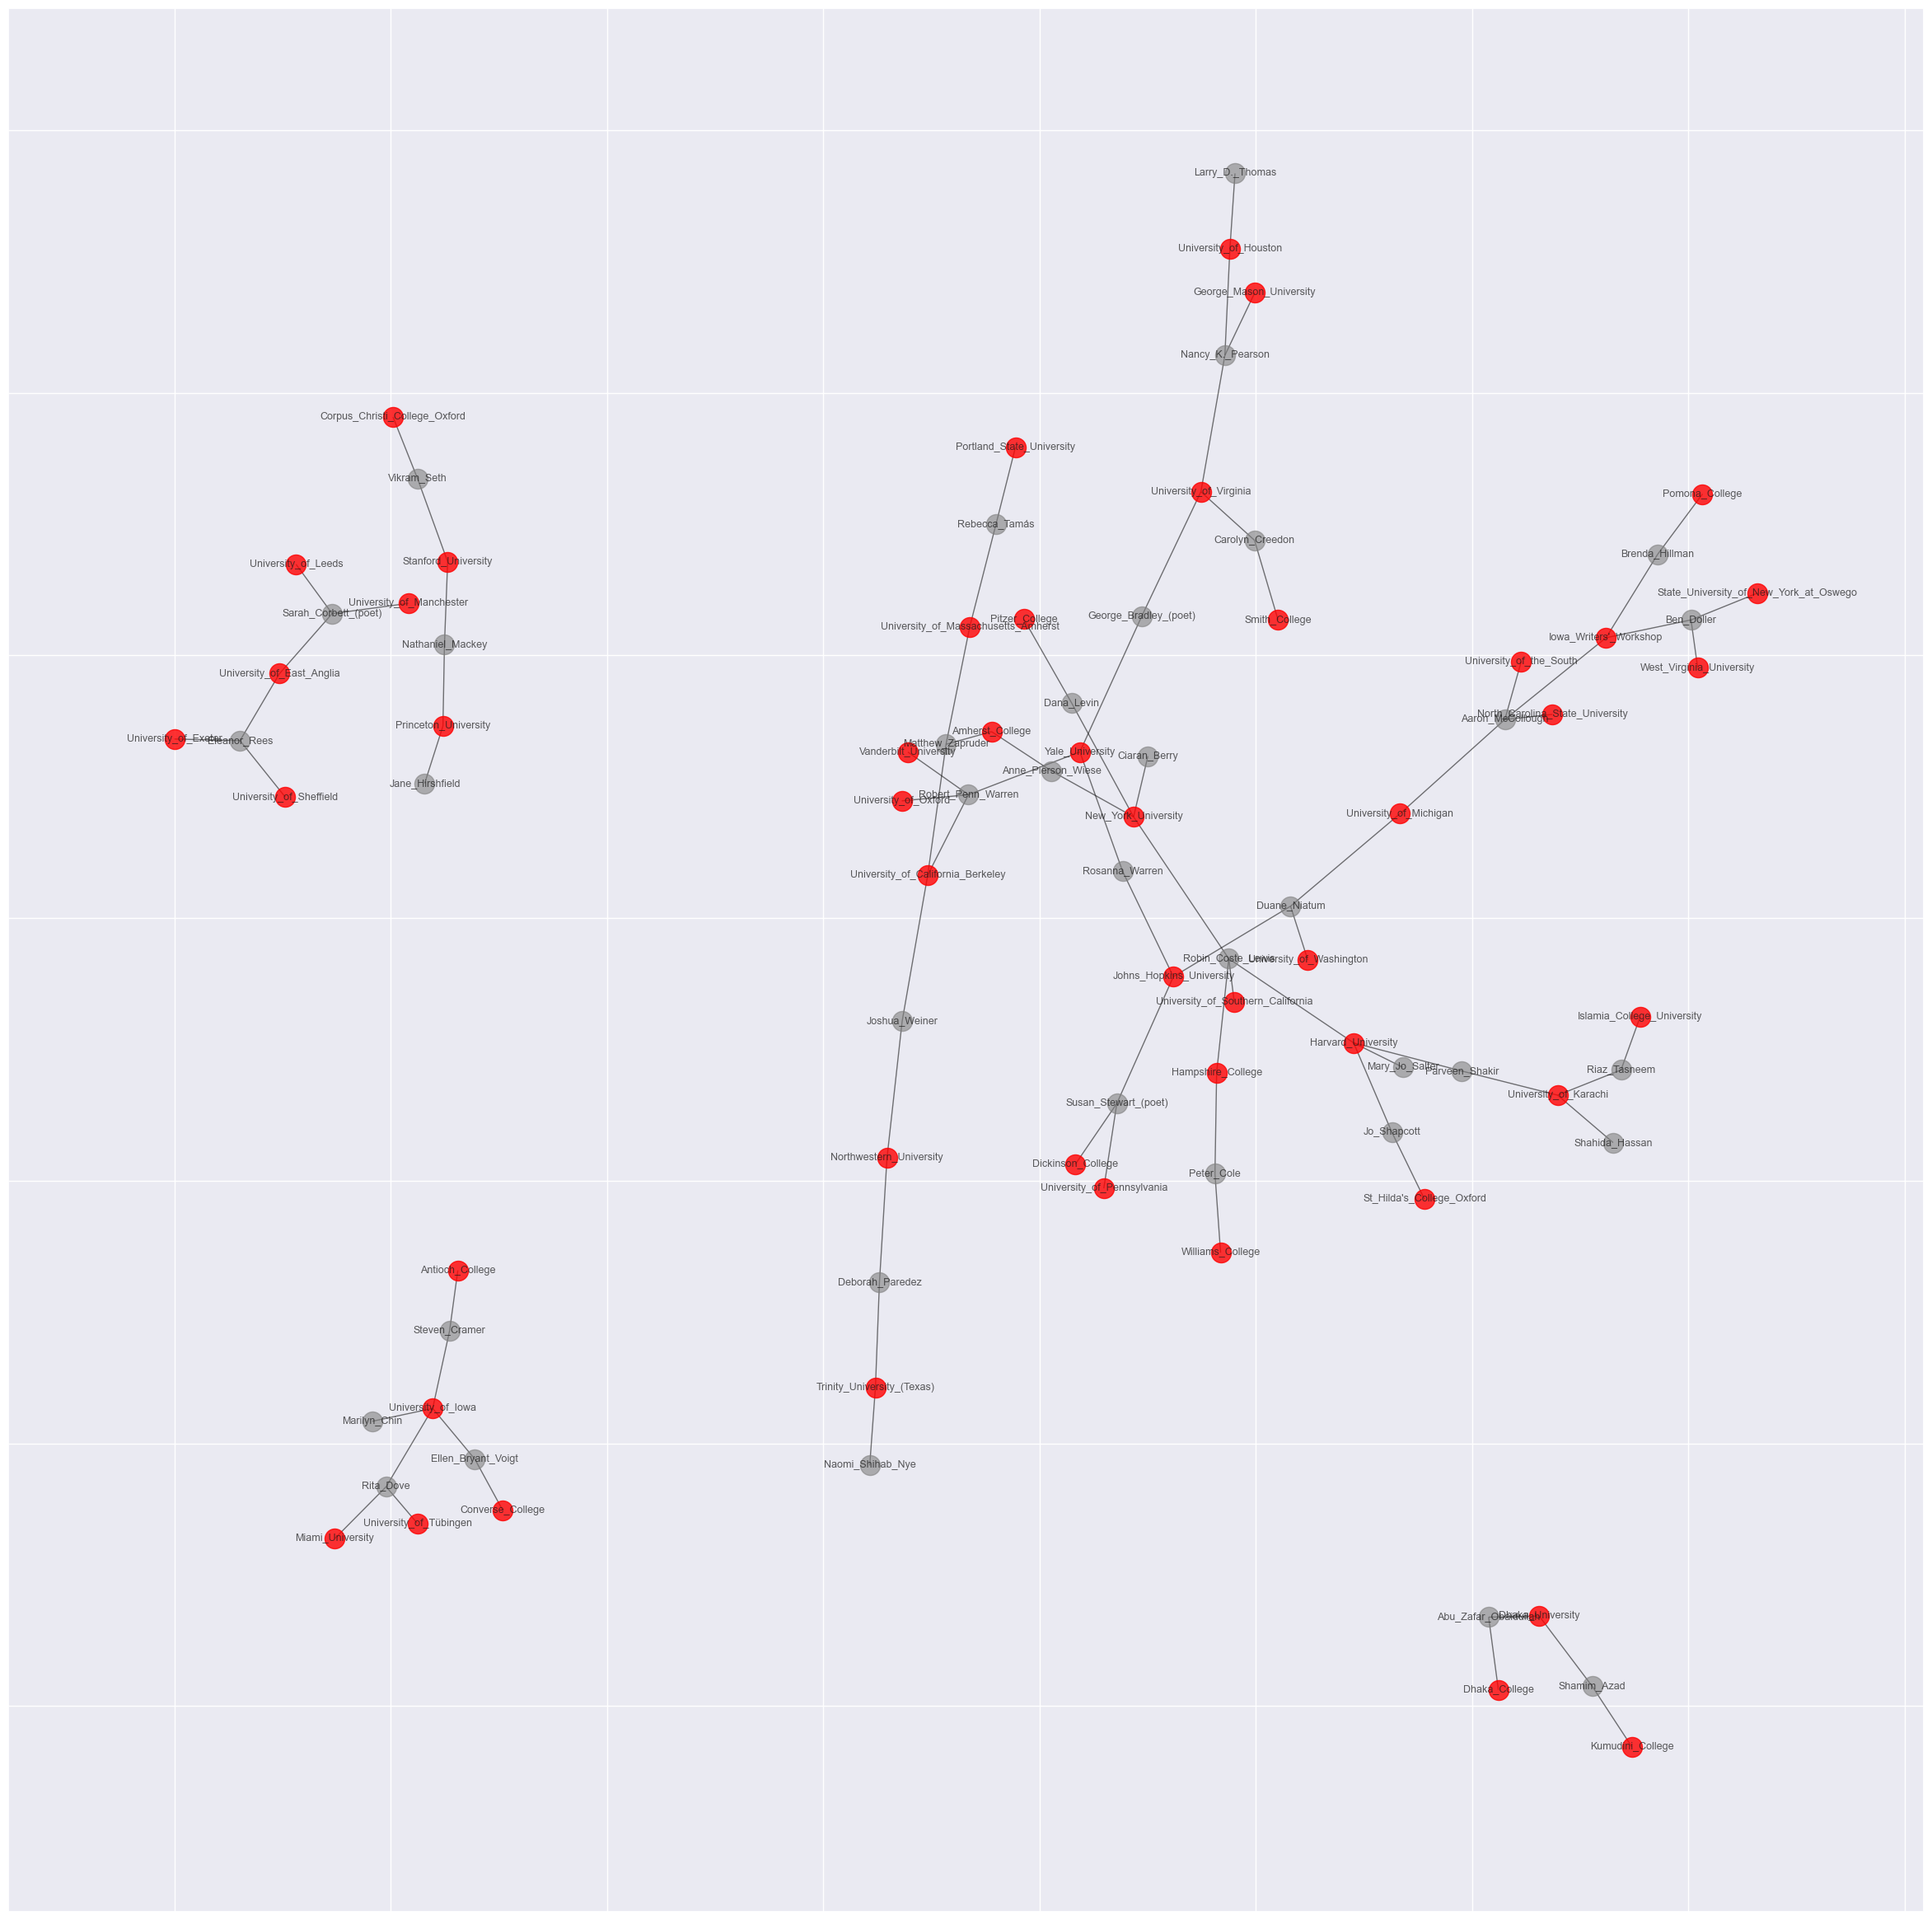

In [639]:
### Visualiser les "écoles", i.e. quelles personnes 
# ont étudié dans la même Université
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)

no = [x for x,y in g.nodes(data=True) if y['type']=='O']
np = [x for x,y in g.nodes(data=True) if y['type']=='P'] 

co = 'red'
cp = 'grey'
nx.draw_networkx_nodes(g, pos, nodelist=np, node_color=cp, alpha=0.6)
nx.draw_networkx_nodes(g, pos, nodelist=no, node_color=co, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=9)


plt.show()

In [640]:
### 
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
#nt = Network( notebook=True) #, filter_menu=True)
# populates the nodes and edges data structures
nt.from_nx(g)

In [641]:
nt.prep_notebook()
#nt.show('pictures/nx.html' )

### Deuxième graphe à deux sommets

In [642]:
l = []
for i in ldf:
    if i['periode'] == '1801_1901':
        l.append(tuple((i['subject_uri'],i['target'], 
                        {'relationship': i['r_property'], "birth_year": i['BirthYear'], "periode": i['periode'] })))
l[:5]

[('Aadan-Gurey_Maxamed_Cabdille',
  'Somali_National_University',
  {'relationship': 'almaMater', 'birth_year': 1840.0, 'periode': '1801_1901'}),
 ('Abel_Bonnard',
  'Université_de_Paris',
  {'relationship': 'almaMater', 'birth_year': 1883.0, 'periode': '1801_1901'}),
 ('Adeline_Dutton_Train_Whitney',
  'George_B._Emerson',
  {'relationship': 'almaMater', 'birth_year': 1824.0, 'periode': '1801_1901'}),
 ('Adeline_Dutton_Train_Whitney',
  'George_B._Emerson',
  {'relationship': 'almaMater', 'birth_year': 1824.0, 'periode': '1801_1901'}),
 ('Albert_Durrant_Watson',
  'Edinburgh_University',
  {'relationship': 'almaMater', 'birth_year': 1859.0, 'periode': '1801_1901'})]

In [643]:
# Graphe Personne- Organisation
POG=nx.Graph()

In [644]:
POG.add_edges_from(l)

In [645]:
### Principales caractéristiques de ce graphe

POG.is_multigraph(), POG.is_directed(), nx.is_connected(POG), POG.number_of_nodes(), POG.number_of_edges(), nx.density(POG)

(False, False, False, 466, 312, 0.002879689879551433)

In [646]:
### Créer une liste des organisations
l_org = list(organisations.index); len(l_org); l_org[:3]

['Abdul_Wali_Khan_University_Mardan',
 'Aberystwyth_University',
 'Academic_Gymnasium_Danzig']

In [647]:
list(POG.nodes.data())[:4]

[('Aadan-Gurey_Maxamed_Cabdille', {}),
 ('Somali_National_University', {}),
 ('Abel_Bonnard', {}),
 ('Université_de_Paris', {})]

In [648]:
### Ajouter au sommets un code si personne ou organisation
# On utiliser pour ce faire la liste des organisations
types = {}
for e in list(POG.nodes):
    if e in l_org:
        t = 'O'
    else:
        t = 'P'
    types[e] = {'type': t} 
[(k,v )for k,v in types.items()][:3]  

[('Aadan-Gurey_Maxamed_Cabdille', {'type': 'P'}),
 ('Somali_National_University', {'type': 'O'}),
 ('Abel_Bonnard', {'type': 'P'})]

In [649]:
nx.set_node_attributes(POG, types)
list(POG.nodes.data())[:3]

[('Aadan-Gurey_Maxamed_Cabdille', {'type': 'P'}),
 ('Somali_National_University', {'type': 'O'}),
 ('Abel_Bonnard', {'type': 'P'})]

In [650]:
### Ajouter la centralité de degré
# grâce à un dictionnaire construit selon le format souhaité
degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(POG)])

In [651]:
nx.set_node_attributes(POG, degree)

In [652]:
print(list(POG.nodes.data())[:4])

[('Aadan-Gurey_Maxamed_Cabdille', {'type': 'P', 'degree': 1}), ('Somali_National_University', {'type': 'O', 'degree': 1}), ('Abel_Bonnard', {'type': 'P', 'degree': 1}), ('Université_de_Paris', {'type': 'O', 'degree': 6})]


In [653]:
persons_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'P':
        persons_degree.append([n[0], n[1]['degree']])

In [654]:
sorted(persons_degree, key = lambda x : x[1], reverse=True)[:10]

[['Xu_Zhimo', 7],
 ['Joseph_R._N._Maxwell', 5],
 ['Dana_Gioia', 3],
 ['Deborah_Digges', 3],
 ['Dora_Gabe', 3],
 ['Fenton_Johnson_(poet)', 3],
 ['Henry_Meade_Bland', 3],
 ['Julia_Alvarez', 3],
 ['Kaiser_Haq', 3],
 ['Kim_Stafford', 3]]

In [655]:
org_degree = []
for n in list(POG.nodes.data()):
    if n[1]['type'] == 'O':
        org_degree.append([n[0], n[1]['degree']])

In [656]:
sorted(org_degree, key = lambda x : x[1], reverse=True)[:10]

[['University_of_São_Paulo', 12],
 ['Harvard_University', 8],
 ['Université_de_Paris', 6],
 ['Columbia_University', 5],
 ['University_of_Vienna', 5],
 ['Trinity_College_Cambridge', 4],
 ['Balliol_College_Oxford', 4],
 ['Smith_College', 4],
 ['University_of_Coimbra', 4],
 ['University_of_Chicago', 3]]

In [657]:
edges = list(POG.edges.data())
edges[:5]

[('Aadan-Gurey_Maxamed_Cabdille',
  'Somali_National_University',
  {'relationship': 'almaMater', 'birth_year': 1840.0, 'periode': '1801_1901'}),
 ('Abel_Bonnard',
  'Université_de_Paris',
  {'relationship': 'almaMater', 'birth_year': 1883.0, 'periode': '1801_1901'}),
 ('Université_de_Paris',
  'Antônio_Peregrino_Maciel_Monteiro_2nd_Baron_of_Itamaracá',
  {'relationship': 'almaMater', 'birth_year': 1804.0, 'periode': '1801_1901'}),
 ('Université_de_Paris',
  'Desanka_Maksimović',
  {'relationship': 'almaMater', 'birth_year': 1898.0, 'periode': '1801_1901'}),
 ('Université_de_Paris',
  'Ion_Pillat',
  {'relationship': 'almaMater', 'birth_year': 1891.0, 'periode': '1801_1901'})]

In [658]:
labels = {}    
for node in POG.nodes():
    labels[node] = node

In [659]:
nx.set_node_attributes(POG, labels, 'label')

In [660]:
nodes = list(POG.nodes.data())
nodes[:5]

[('Aadan-Gurey_Maxamed_Cabdille',
  {'type': 'P', 'degree': 1, 'label': 'Aadan-Gurey_Maxamed_Cabdille'}),
 ('Somali_National_University',
  {'type': 'O', 'degree': 1, 'label': 'Somali_National_University'}),
 ('Abel_Bonnard', {'type': 'P', 'degree': 1, 'label': 'Abel_Bonnard'}),
 ('Université_de_Paris',
  {'type': 'O', 'degree': 6, 'label': 'Université_de_Paris'}),
 ('Adeline_Dutton_Train_Whitney',
  {'type': 'P', 'degree': 1, 'label': 'Adeline_Dutton_Train_Whitney'})]

In [661]:
components = nx.connected_components(POG);
components_l = [len(c) for c in sorted(nx.connected_components(POG), key=len, reverse=True)]
len(components_l), components_l[:5]

(154, [38, 16, 13, 8, 7])

In [662]:
S = [POG.subgraph(c).copy() for c in nx.connected_components(POG)]

In [663]:
ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

[[8, 38], [1, 16], [28, 13], [76, 8], [7, 7], [96, 7], [40, 6], [43, 6]]

In [664]:
li=[n[0] for n in ln]

In [665]:
S[21].nodes 

NodeView(('University_of_Wisconsin–Madison', 'August_Kleinzahler', 'University_of_Victoria'))

In [666]:
u = S[14]

In [667]:
u = nx.Graph()
for i in li[:5]:
    u = nx.union(u, S[i])
type(u)    

networkx.classes.graph.Graph

In [668]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)

(False, False, 82, 77, 0.02318578741342969)

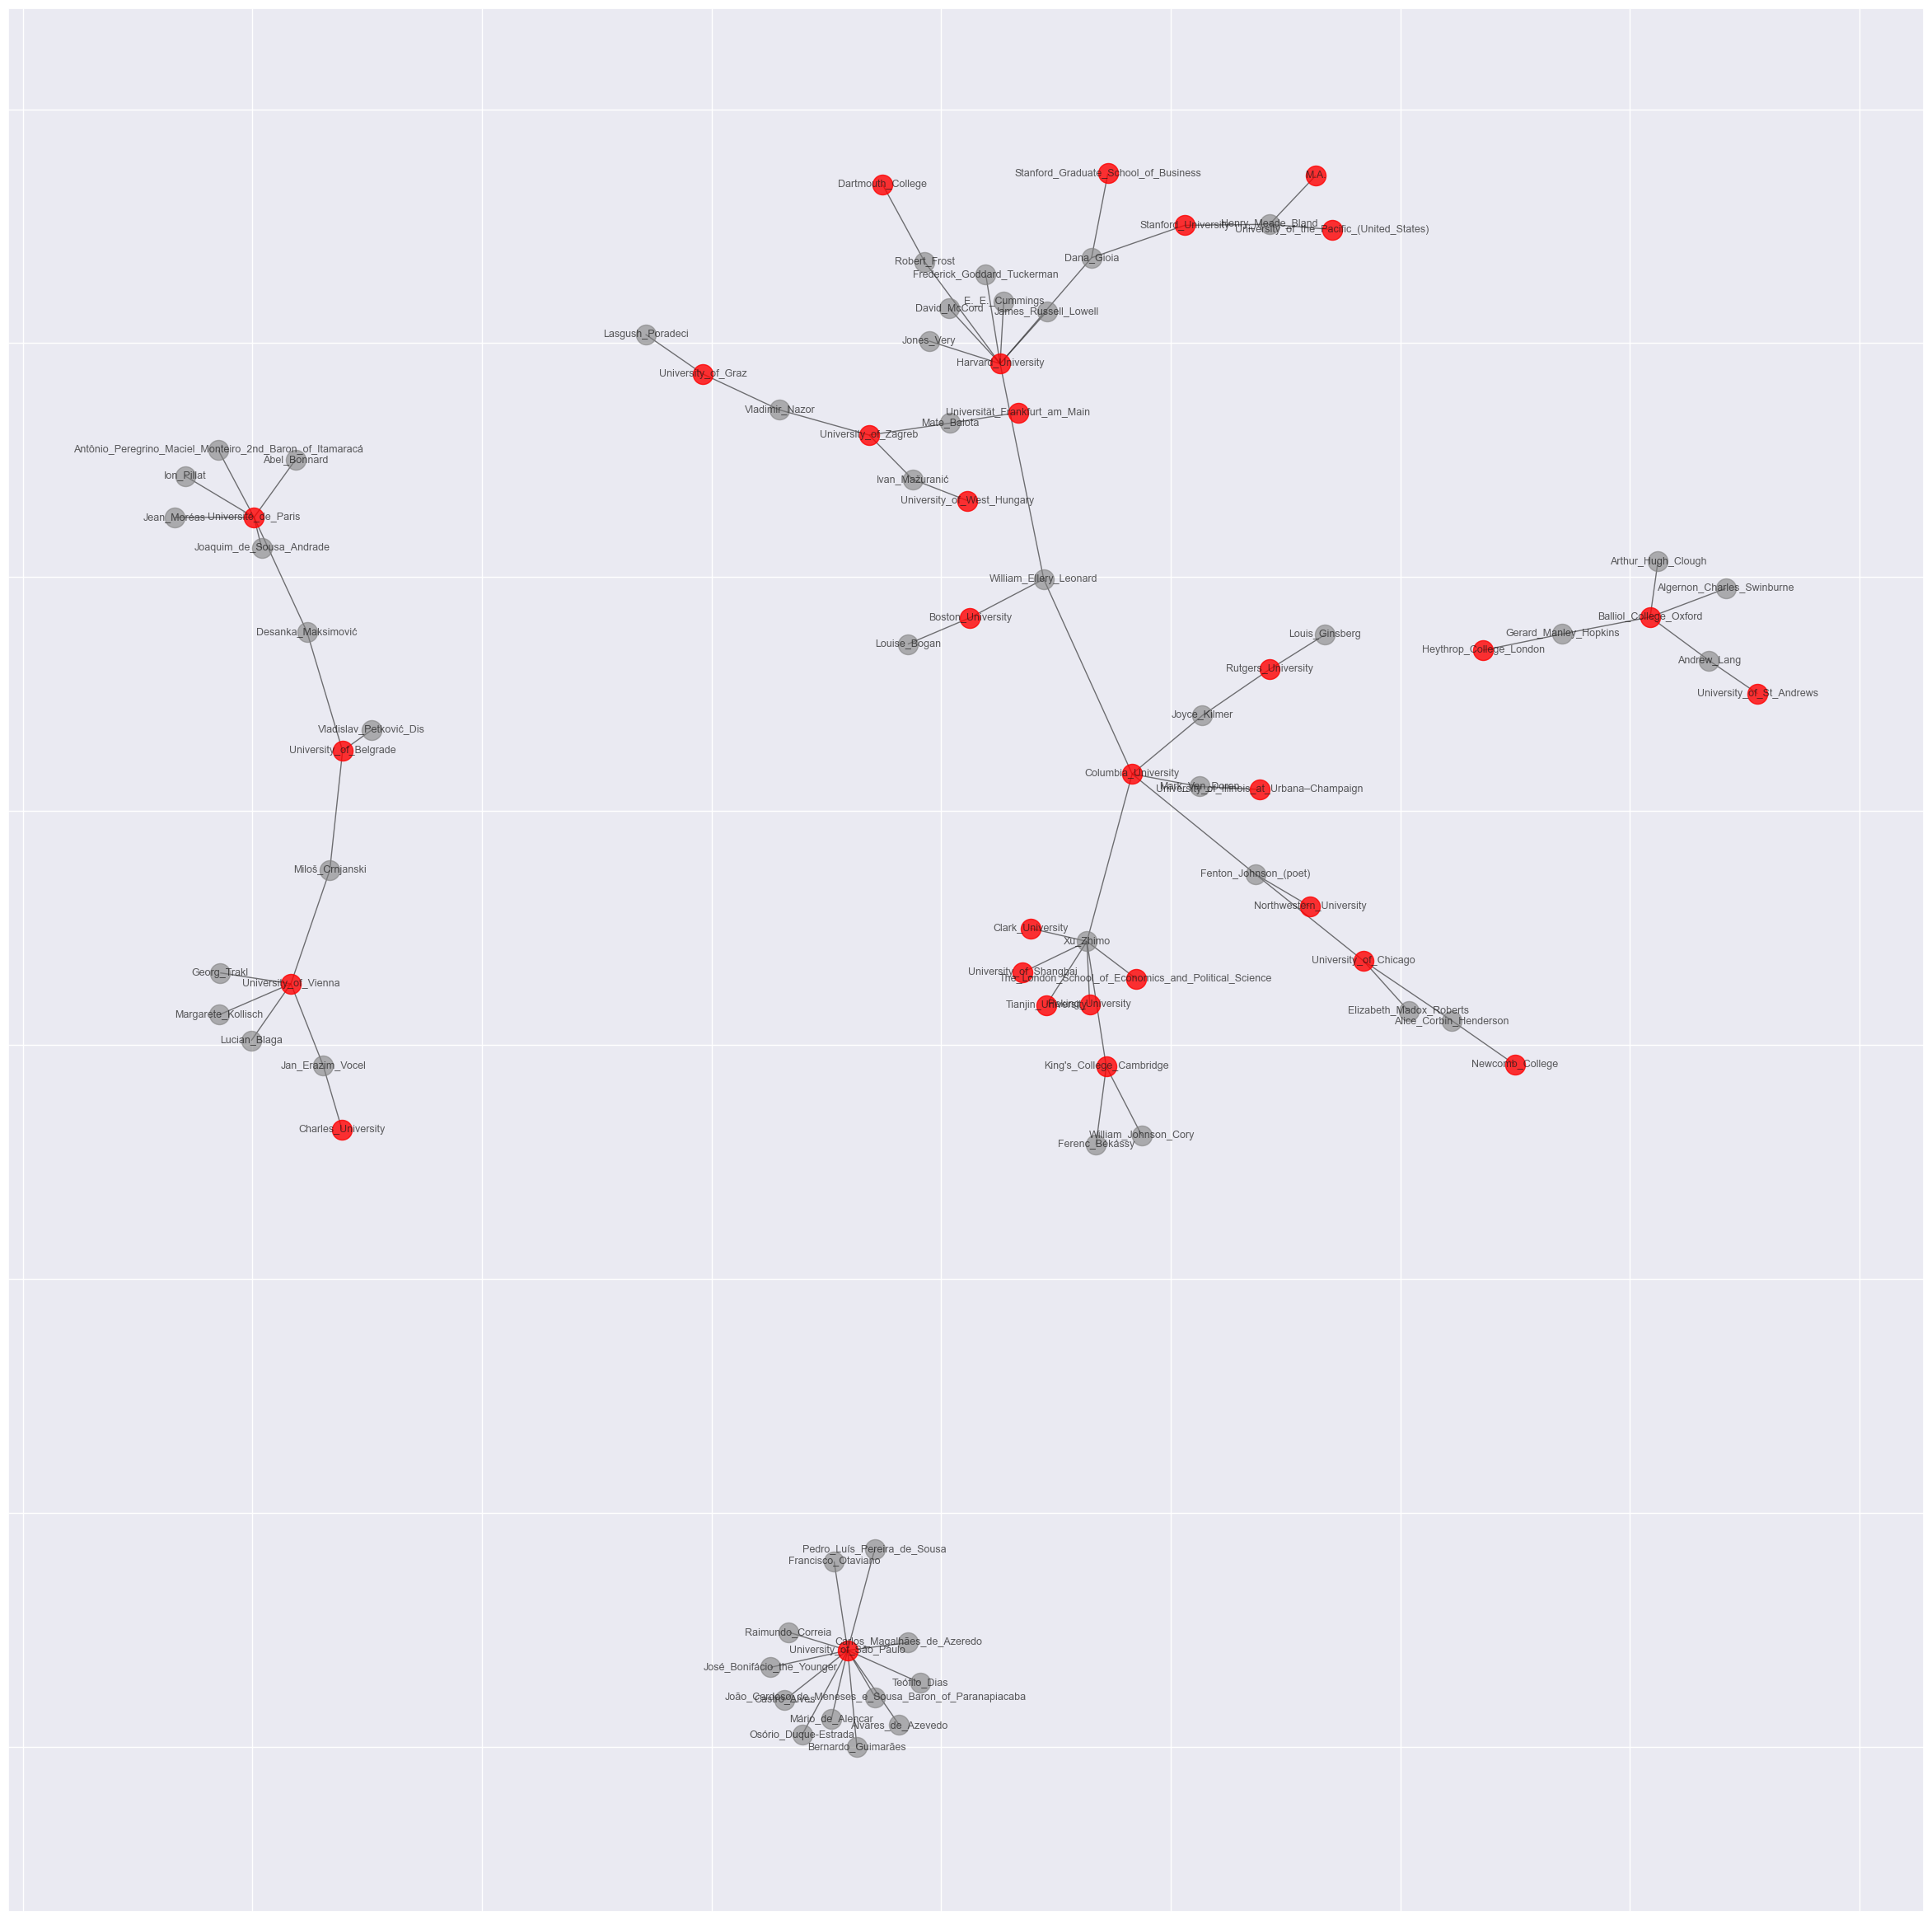

In [669]:
### Visualiser les "écoles", i.e. quelles personnes 
# ont étudié dans la même Université
# https://networkx.org/documentation/stable/reference/drawing.html
plt.figure(figsize = (30,30))

#g = POG
g = u

#pos = nx.kamada_kawai_layout(g)
pos = nx.spring_layout(g)

no = [x for x,y in g.nodes(data=True) if y['type']=='O']
np = [x for x,y in g.nodes(data=True) if y['type']=='P'] 

co = 'red'
cp = 'grey'
nx.draw_networkx_nodes(g, pos, nodelist=np, node_color=cp, alpha=0.6)
nx.draw_networkx_nodes(g, pos, nodelist=no, node_color=co, alpha=0.8)
nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=9)


plt.show()

In [670]:
### Pairs de personnes
#pairs_p = []

#for s1 in ldf:
    #for s2 in ldf:
        #if s1['subject_uri'] < s2['subject_uri'] \
            #and s1['target'] == s2['target'] \
            #and s2['YEnd'] > s1['YBegin'] \
            #and s2['YBegin'] < s1['YEnd']:
            #pairs_p.append([s1,s2])
        #else:
            #pass

In [671]:
#len(pairs_p)

In [672]:
#pairs_p[:2]

### Créer les pairs d'organisations

Une personne fait le lien entre deux organisations

In [673]:
## Pairs d'organisations
#pairs_o = []

#for s1 in ldf:
    #for s2 in ldf:
        #if s1['target'] < s2['target'] \
            #and s1['subject_uri'] == s2['subject_uri']:
                #pairs_o.append([s1,s2])
        #else:
            #pass

In [674]:
#len(pairs_o)

In [675]:
### Apparaissent des parcours de vie
#pairs_o[:2]

## Réseaux de personnes (filtres, sous-populations)

In [676]:
#earlyModern_pairs = [p for p in pairs_p if ((p[0]['periode']=='1901_2021') & (p[1]['periode']=='1901_2021'))]

In [677]:
#len(earlyModern_pairs), earlyModern_pairs[:3]

In [678]:
#almaMater_pairs = [p for p in pairs_p if ((p[0]['r_property'] == 'almaMater') & (p[1]['r_property'] == 'almaMater'))]

In [538]:
#len(almaMater_pairs), almaMater_pairs[:2]

## Exploration des graphes de personnes

In [539]:
### Préparer pour créer le graphe
#l = []
#for i in earlyModern_pairs: #almaMater_pairs:
    #l.append(tuple((i[0]['subject_uri'],i[1]['subject_uri'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}", 
                                                              #'organisation': i[0]['target'] })))
#l[:5]

In [540]:
#EMP=nx.Graph()

In [541]:
#EMP.add_edges_from(l)

In [542]:
### Principales caractéristiques de ce graphe

#EMP.is_multigraph(), EMP.is_directed(), nx.is_connected(EMP), EMP.number_of_nodes(), EMP.number_of_edges(), nx.density(EMP)


In [543]:
#nodes = list(EMP.nodes.data())
#nodes[:5]

In [544]:
#edges = list(EMP.edges.data())
#edges[:5]

In [546]:
#labels = {}    
#for node in EMP.nodes():
    #labels[node] = node

In [547]:
### 
# https://pyvis.readthedocs.io/en/latest/tutorial.html#using-pyvis-within-jupyter-notebook
#nt = Network( notebook=True) #, filter_menu=True)
# populates the nodes and edges data structures
#nt.from_nx(EMP)
#nt.prep_notebook()
#nt.show('pictures/emp.html' )

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [548]:
#components = nx.connected_components(EMP);
#components_l = [len(c) for c in sorted(nx.connected_components(EMP), key=len, reverse=True)]
#len(components_l), components_l[:5]

In [549]:
#S = [EMP.subgraph(c).copy() for c in nx.connected_components(EMP)]

In [550]:
#ln = sorted([[i,len(s.nodes)] for i,s in enumerate(S)], key = lambda row: row[1], reverse=True); ln[:8]

In [551]:
#li=[n[0] for n in ln]

### Représenter le graphe

In [552]:
#u = nx.Graph()
#for i in li[1:3]:
    #u = nx.union(u, S[i])
#type(u)    

In [553]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

## ,nx.is_connected(G_1971_1975)
#u.is_multigraph(), u.is_directed(), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


In [554]:
#u = S[5]

In [555]:
# https://networkx.org/documentation/stable/reference/drawing.html
#plt.figure(figsize = (30,30))

#g = POG
#g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
#pos = nx.spring_layout(g, k=1)

#labels = {e: u.get_edge_data(e[0], e[1])["organisation"] for e in u.edges()}

#cp = 'grey'
#nx.draw_networkx_nodes(g, pos, node_color=cp, alpha=0.8)
#nx.draw_networkx_edges(g, pos, alpha=0.6) # edgelist=ln, edge_color=c, 
#nx.draw_networkx_labels(g, pos, alpha=0.7, font_size=11)
#nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)



#plt.show()


## Explorer le graphe des organisations (relation Alma Mater)

In [556]:
### Apparaissent des parcours de vie
#pairs_o[:2]

In [557]:
#l = []
#for i in pairs_o:
    #if i[0]['r_property'] == 'almaMater' or  i[1]['r_property'] == 'almaMater':
        #l.append(tuple((i[0]['target'],i[1]['target'], {'relationship': f"{i[0]['r_property']}_{i[1]['r_property']}", 
                                                              #'personne': i[0]['subject_uri'] })))
#len(l), l[:3]        

In [558]:
### Graphe des organisation, liens AlmaMater

#amO=nx.Graph()

In [559]:
#amO.add_edges_from(l)

In [561]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
#amO.is_multigraph(),nx.is_connected(amO) , amO.number_of_nodes(), amO.number_of_edges(), nx.density(amO)


In [562]:
#nodes = list(amO.nodes.data())
#nodes[:5]

In [563]:
#edges = list(amO.edges.data())
#edges[:5]

### Analyser les composantes du graphe

Documentation: https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.components.connected_components.html

In [564]:
#components = nx.connected_components(amO);
#components_l = [len(c) for c in sorted(nx.connected_components(amO), key=len, reverse=True)]
#len(components_l), components_l[:5]

In [565]:
#largest_cc = max(nx.connected_components(amO), key=len); type(largest_cc)

In [566]:
#S = amO.subgraph(largest_cc).copy()
#type(S)


In [567]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
#S.is_multigraph(),nx.is_connected(S) , S.number_of_nodes(), S.number_of_edges(), nx.density(S)


### Centralité de degré

Documentation: [degree_centrality(G)](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.degree_centrality.html#networkx.algorithms.centrality.degree_centrality)

In [568]:
# On construit ici le dictionnaire selon le format souhaité
#degree = dict([(d[0], {'degree': d[1]}) for d in nx.degree(S)])

In [569]:
#nx.set_node_attributes(amO, degree)
#print(list(amO.nodes.data())[:3])

### Centralité de proximité

Compute [closeness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.closeness_centrality.html#networkx.algorithms.centrality.closeness_centrality) for nodes.


In [472]:
#closeness = nx.closeness_centrality(amO)

In [570]:
#nx.set_node_attributes(amO, closeness, 'closeness')
# print(G.nodes.data())

### Centralité d'intermédiarité

[Betweenness centrality](https://networkx.org/documentation/stable/reference/algorithms/generated/networkx.algorithms.centrality.betweenness_centrality.html#networkx.algorithms.centrality.betweenness_centrality)

In [474]:
#betweenness = nx.betweenness_centrality(amO)

In [475]:
#nx.set_node_attributes(amO, betweenness, 'betweenness')


In [571]:
### Exporter les attributs vers un DataFrame afin de les explorer
#export = pd.DataFrame(amO.nodes.data(), columns = ['id', 'attributes'])
#export = export.set_index('id')
#export.head()

In [572]:
### Décomposer le champs attributs en colonnes
# https://stackoverflow.com/questions/38231591/split-explode-a-column-of-dictionaries-into-separate-columns-with-pandas

#attributes = pd.json_normalize(export.attributes)

## Retour à affichage des décimales par défaut:
#pd.options.display.float_format = '{: }'.format  # pour 4 chiffres : 4f


#round(attributes, 4)

In [573]:
### appliquer au DataFrame et supprimer la colonne attributes
# en même temps mettre le nom en index
# export = export.join(pd.json_normalize(export.attributes)).set_index('id')
#export = export.join(attributes)
#export = export.drop(columns=['attributes'],axis=1)
#export.head()

In [574]:
#round(export.sort_values(by=['degree'], ascending=False),3)

In [575]:
#export['degree'].describe()

In [576]:
### Violinplot : densité des naissances dans le temps
#  https://mode.com/blog/violin-plot-examples/
#  https://seaborn.pydata.org/generated/seaborn.violinplot.html#seaborn.violinplot

#sns.set_theme(style="whitegrid")

#sns.set(rc={"figure.figsize":(14, 7)})

#a = export['degree'].dropna()
#lim_left=min(a)
#lim_right=max(a)





#ax = sns.violinplot(x=a)

### Noter que au delà des limites les valeurs sont coupées car postulées
#ax.set_xlim(left=lim_left, right=lim_right)


In [577]:
#kamo = nx.k_core(amO, k=5)

In [578]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html

##amO.is_directed() ,nx.is_connected(G_1971_1975)
#kamo.is_multigraph(),nx.is_connected(kamo) , kamo.number_of_nodes(), kamo.number_of_edges(), nx.density(kamo)


In [579]:
#components = nx.connected_components(kamo);
#components_l = [len(c) for c in sorted(nx.connected_components(kamo), key=len, reverse=True)]
#len(components_l), components_l[:5]

In [485]:
#largest_cc = max(nx.connected_components(kamo), key=len)

In [580]:
#S = kamo.subgraph(largest_cc).copy()
#type(S)


### Représenter le graphe

In [581]:
### Principales caractéristiques de ce graphe

# MultiGraph: Undirected graphs with self loops and parallel edges
# https://networkx.org/documentation/stable/reference/classes/index.html
#u = S
## ,nx.is_connected(G_1971_1975) u.is_directed(),
#u.is_multigraph(), nx.is_connected(u), u.number_of_nodes(), u.number_of_edges(), nx.density(u)


In [582]:
#list(u.nodes.data())[1:3]

In [583]:
#labels = {}
#for i in list(u.nodes.data()):
 #   if i[1]['degree'] > 15:
  #      labels[i[0]]=i[0] 
#list(labels.items())[:3]

In [584]:
# https://networkx.org/documentation/stable/reference/drawing.html
#plt.figure(figsize = (30,30))

#g = POG
#g = u

#pos = nx.kamada_kawai_layout(g)
### https://networkx.org/documentation/stable/reference/generated/networkx.drawing.layout.spring_layout.html
#pos = nx.spring_layout(g, k=1)

#labels = {}
#for i in list(u.nodes.data()):
   # if i[1]['degree'] > 30:
    #    labels[i[0]]=i[0] 

#node_color = [i[1]['degree'] for i in list(u.nodes.data())]

### Adapter la taille des attribut à l'affichage
#node_sizes = [i[1]['betweenness']**2 * 100000 + 10 for i in list(u.nodes.data())]


#cp = 'grey'
#nx.draw_networkx_nodes(g, pos, node_size=node_sizes, node_color=node_color, 
                     # cmap='copper', alpha=0.6)
#nx.draw_networkx_edges(g, pos, alpha=0.05) # edgelist=ln, edge_color=c, 
#nx.draw_networkx_labels(g, pos, labels=labels,  alpha=0.7, font_size=11)
#nx.draw_networkx_edge_labels(g, pos=pos, edge_labels=labels)

#f = 'pictures/universites.svg'# io.BytesIO()

#plt.savefig(f, format="svg")

#plt.show()
